In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os, math
import matplotlib.image as mpimg
import torch
import matplotlib as mpl
from skimage import io
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import copy
from sklearn.decomposition import PCA
import seaborn as sns
import torchvision.models as models
import torch.nn.functional as F
from glob import glob
import cv2
from src.utility import preprocess_image, convert_image_np, getImageNetDict, getImageNetCodeDict
import torch.optim as optim
import torch.nn as nn
import copy, time
from torchvision import transforms, utils
import tqdm
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
from collections import Counter
from src.parallel_run import map_parallel
from joblib import Parallel, delayed
import multiprocessing
import os.path

In [2]:
alexnet = models.alexnet(pretrained=True)
imagenetdict = getImageNetDict()
imagenetcodedict = getImageNetCodeDict()
name2code = dict((v, k) for k, v in imagenetcodedict.items())
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d (64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d (192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d (384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_features=4096)
    (5): ReLU(inplace)
    (6): Linea

In [69]:
def to_var(x, *args, **kwargs):
    if type(x) is list or type(x) is tuple:
        x = [Variable(x_, *args, **kwargs) for x_ in x]
    else:
        x = Variable(x, *args, **kwargs)
    return x

# display the basis vectors
def preprocess_im(im, volatile=False):
    original_image = cv2.imread(im)
    prep_img = preprocess_image(original_image)
    if volatile:
        prep_img.volatile = True
    return prep_img

def show_image(images, title=''):
    seq = []
    for im in images:
        prep_img = preprocess_im(im, volatile=True)
        seq.append(prep_img)
    images_batch = torch.cat(seq, dim=0)
    grid = utils.make_grid(images_batch.data)   
    plt.imshow(convert_image_np(grid))
    plt.title(title)
    plt.show()
    
def show_concepts(concepts):
    prefix = 'tiny-imagenet-200/train/'
    res = []
    for c in concepts:
        name = prefix + name2code[c]
        all_pics = glob(name + '/images/*')
        rs = np.random.choice(range(len(all_pics)), 8, replace=False)
        res.extend([all_pics[r] for r in rs])
    
    plt.figure(figsize=(10,10))
    show_image(res)
    plt.show()
    
def generate_basis(concept_class, W):
    n_per_class = math.ceil(W.shape[1] / len(concept_class))
    prefix = 'tiny-imagenet-200/train/'
    res = []
    concepts = []
    for c in concept_class:
        name = prefix + name2code[c]
        all_pics = glob(name + '/images/*')
        rs = np.random.choice(range(len(all_pics)), n_per_class, replace=False)
        res.extend([all_pics[r] for r in rs])
        concepts.extend([name2code[c] for r in rs])
        
    order = np.random.permutation(W.shape[1])
    res = np.array(res)[order]
    concepts = np.array(concepts)[order]
    return res, concepts

def get_test_images(concept_class):
    anno = 'tiny-imagenet-200/val/val_annotations.txt'
    d = {}
    with open(anno) as f:
        for l in f:
            k, v = l.split()[:2]
            d[k] = v
            
    prefix = 'tiny-imagenet-200/val/images/'
    images = []
    labels = []
    for im in glob(prefix + '*'):
        c = d[im.split('/')[-1]]
        if imagenetcodedict[c] in concept_class:
            images.append(im)
            labels.append(c)
    return images, labels

def predict(net, im):
    net.eval()
    prep_img = preprocess_im(im)
    prediction = net(prep_img).data.cpu().numpy().argmax()
    return imagenetdict[prediction], prediction

def extract_features(net, images):
    net.eval()
    seq = []
    for im in tqdm.tqdm(images):
        prep_img = preprocess_im(im, volatile=True)
        seq.append(prep_img)
        
    features = []
    for i in tqdm.tqdm(range(0, len(seq), 100)):
        images_batch = torch.cat(seq[i:i+100], dim=0)
        features.append(net(images_batch))
    return torch.cat(features, dim=0)

def check_ortho(theta_list, plot=False, verbose=False):
    Q = [t/np.linalg.norm(t) for t in theta_list]
    Q = np.vstack(Q).T
    error = np.sum(np.abs(Q.T.dot(Q) - np.eye(Q.shape[1])))
    if verbose:
        print("orthogonal check error: ", error)
    if plot:
        print(Q.T.dot(Q))
        plt.matshow(Q.T.dot(Q))
        plt.show()
    return error
    
def orthogonize_(theta, prev_theta_list):
    '''goal: theta should be orthogonal to all vectors in prev_theta_list'''
    theta = theta / np.linalg.norm(theta)
    for t in prev_theta_list:
        theta = theta - theta.dot(t) / np.dot(t,t) * t 
    return theta

def orthogonize(theta, prev_theta_list, verbose=False):
    done = len(prev_theta_list) == 0
    while not done:
        theta = orthogonize_(theta, prev_theta_list)
        #check_ortho(prev_theta_list, plot=False)        
        #check_ortho(prev_theta_list + [theta], plot=False)
        #print('in middle', theta)
        #print(check_ortho(prev_theta_list + [theta]))
        #if  check_ortho(prev_theta_list + [theta]) > 1e-3:
            #print(check_ortho(prev_theta_list + [theta]))
        if np.linalg.norm(theta) < 1e-10: # give a random direction to theta to theta too close to 0
            if verbose:
                print('restart a vector')
            theta = np.random.randn(len(theta))
        else:
            done = True
        
    return theta / np.linalg.norm(theta) # to keep theta in a good range for numerical stability

def ortho_inverse(P):
    out = copy.deepcopy(P.T)
    div = np.diag(P.T.dot(P))
    for i, v in enumerate(div):
        out[i] /= v
    return out

def data_range(A, t):
    return A.dot(t/t.dot(t)).ravel().std()

def normalize_theta(A, t):
    drange = data_range(A, t)
    if drange == 0: # no need to normalize
        return t
    return t * drange # multiply so that in P^-1 is divide by

def print_result(W, concepts, errors, threshold=0.1, mask=True):
    coe = W
    print('"*" postfixed means error < %.4f' % threshold)
    print('%15s %10s %10s' % ('concepts', 'coeff', 'error'))
    print('-'*37)
    for w, c, e in sorted(zip(coe, concepts, errors), key=lambda x: abs(x[0]), reverse=True):
        if e < threshold:
            c = c+"*"
        else:
            if mask: c = 'unknown'
        print("%15s %10.4f %10.4f" % (c, w, e))   

def eval_direction(theta, c, l, A, plot=False, verbose=False):
    '''concept c, labels l, activation map A'''
    y = np.zeros(len(l))
    y[np.array(l) == c] = 1
    
    n, d = A.shape
    a = A.dot(theta).ravel()
    X = np.vstack([a, np.ones(n)]).T
    
    #print(X.shape, y.shape)
    
    m, b = np.linalg.lstsq(X, y)[0]
    error = np.mean((X.dot(np.array([m,b])) - y)**2)
    
    if verbose:
        print('%s error: %.4f, slope: %+.4f, intercept: %+4f' % (c.ljust(14), error, m, b))        
    if plot:
        colors = list(map(switch_color, l))
        transformed = X.dot(np.array([m,b]))
        plt.scatter(transformed, transformed + np.random.random(n), c=colors)
        plt.show()
    return error, m, b

def interpret_direction(t, concepts_list, labels, A):
    min_e = 1000
    min_c = ""
    min_m = 0
    for c in concepts_list:
        e, m, b = eval_direction(t, c, labels, A)
        if e < min_e:
            min_e = e
            min_c = c
            min_m = m
    return min_e, min_m, min_c 

def plot_inter_stats(directions, neuron_numbers, concepts, labels, A, plot=True):
    theta_list = []
    errors = []
    used_concepts = []
    for i in tqdm.tqdm(neuron_numbers):
        direction = directions[i]
        e, m, c = interpret_direction(direction, concepts, labels, A) 
        if m < 0:
            direction = -direction
        theta_list.append(direction)
        errors.append(e)
        used_concepts.append(c)

    if plot:
        sns.distplot(errors)
        plt.ylabel('frequency')
        plt.xlabel('interpretable error')
        plt.show()
    return errors, used_concepts

def print_mean_std(errors, name=""):
    m, s = np.mean(errors), np.std(errors)
    print(('%20s mean: %.3f, std: %.4f') % (name, m, s))
    
def concept_scatter(a, concepts, labels):
    for c in concepts:
        a_ = a[labels==c]
        plt.scatter(a_, a_ + np.random.random(len(a_))*3, label=imagenetcodedict[c])
    plt.legend()
    
class LR(nn.Module): # logistic regression with 2 neurons
    def __init__(self, input_size, output_size=2):
        super().__init__()
        
        self.i2o = nn.Linear(input_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.output_size = output_size
        self.input_size = input_size
        
    def forward(self, input):
        output = self.softmax(self.i2o(input))
        return output

def get_y(c, l, A):
    '''concept c, labels l, activation map A'''
    y = np.zeros(len(l))
    y[np.array(l) == c] = 1
    return y   

def plotDirection(direction, A, l, concepts):
    plt.figure(figsize=(7,7))
    e, m, c = interpret_direction(direction, concepts, l, A) 
    if m < 0:
        direction = -direction
    a = A.dot(direction)
    if a.std() != 0:
        a = a / a.std()
    concept_scatter(a, concepts, np.array(l))
    plt.title('%s error: %.4f' % (imagenetcodedict[c], e))    
    
def train(net, trainloader, criterion, optimizer, print_every=None, epochs=2, max_time=10):
    start = time.time()
    
    # max_time given in seconds
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            
            end = time.time()
            if end - start >= max_time:
                print('Finished Training in %ds' % (end-start))                
                return
            
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(to_var(inputs))
            loss = criterion(outputs, to_var(labels))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
            if print_every is not None and i % print_every == (print_every-1): 
                print('[%d, %5d] loss: %.10f' %
                      (epoch + 1, i + 1, running_loss / print_every))
                running_loss = 0.0

    print('Finished Training in %ds' % (end-start))

def custom_solve(A, y, max_time=3):
    concept_lr_data = TensorDataset(torch.from_numpy(A), torch.from_numpy(y).long())
    trainloader = DataLoader(concept_lr_data, batch_size=32, num_workers=0) # num_workers=0 makes sure can parallelize
    
    concept_net = LR(4096)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(concept_net.parameters())
    train(concept_net, trainloader, criterion, optimizer, print_every=None, epochs=5, max_time=max_time)   
    
    theta = concept_net.i2o.weight
    theta = (theta[1] - theta[0]).data.numpy()
    return theta

def custom_leastsq_concept(c, l, A, max_time=3):
    '''concept c, labels l, activation map A'''
    y = get_y(c, l, A)
    theta = custom_solve(A, y, max_time=max_time)
    return theta

def number_interpretable(errors, threshold):
    return sum(np.array(errors) < threshold)

def plot_number_interpretable(name, errors, thresholds):
    nums = []
    for t in thresholds:
        nums.append(number_interpretable(errors, t))
    plt.plot(thresholds, nums, 'o-', label=name)
    plt.xlabel('threshold')
    plt.ylabel('#interpretable')


In [4]:
model = copy.deepcopy(alexnet)
model.classifier = nn.Sequential(*list(alexnet.classifier.children())[:-1])
W = list(alexnet.classifier.children())[-1].weight.cpu().data.numpy()
net = alexnet

# choose 9 classes

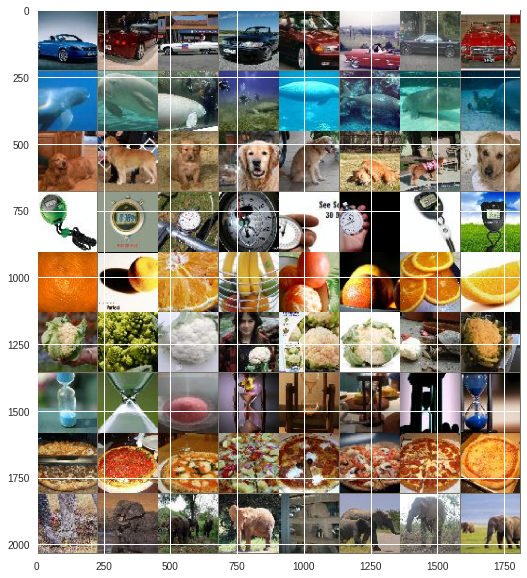

In [5]:
concept_classes = ['convertible', 'dugong', 'golden_retriever', 'stopwatch', 'orange', 'cauliflower', 'hourglass', 'pizza', 'African_elephant']
show_concepts(concept_classes)

In [6]:
basis, labels = generate_basis(concept_classes, W)
concepts = set(labels)
#plt.figure(figsize=(15,15))
#show_image(basis[:64])

In [7]:
features = extract_features(model, basis)
P = features.transpose(0,1).data.cpu().numpy()

100%|██████████| 41/41 [03:49<00:00,  5.59s/it]


In [8]:
# temporary activations
activations = P.T
A = activations # A should be n x r
print(A.shape)

(4096, 4096)


In [9]:
test_images, test_labels = get_test_images(concept_classes)
features_test = extract_features(model, test_images)
A_test = features_test.data.cpu().numpy()

100%|██████████| 5/5 [00:24<00:00,  4.93s/it]


In [10]:
newW = W.dot(P)
print(newW.shape)

(1000, 4096)


In [11]:
def visContribution(W, predict_id=940, top=10, test_image_name=None, coordinate=True, use_abs=True):
    
    if test_image_name is not None:
        word, predict_id = predict(net, test_image_name)
        print(word, predict_id)
    else:
        word = imagenetdict[predict_id]

    # an example explaination: W 1000 x num_basis
    weights = W[predict_id]

    if test_image_name is not None:
        b = extract_features(model, [test_image_name])[0].data.cpu().numpy()
        x = lst_solve(A, b)
        if coordinate:
            if not use_abs:
                criteria = x
            else:
                criteria = np.abs(x)
        else:
            if not use_abs:
                criteria = x
            else:
                criteria = np.abs(weights * x)
        args = np.argsort(criteria)[::-1]
    else:
        if not use_abs:
            args = np.argsort(weights)[::-1]
        else:
            args = np.argsort(np.abs(weights))[::-1]

    # visualize
    selection = args[:top]
    print('%s =' % word)

    theta = weights[selection]
    images = np.array(basis)[selection]
    
    if test_image_name is not None:
        input_weights = x[selection]
        original_image = cv2.imread(test_image_name)
        correct_color_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        plt.imshow(correct_color_image)
        plt.axis('off')
        plt.title('this image =')
        plt.show()
    
    ncols = min(top, len(images))
    fig, ax = plt.subplots(ncols=ncols)
    fig.set_figheight(10)
    fig.set_figwidth(20)

    for i, col in enumerate(ax):
        original_image = cv2.imread(images[i])
        correct_color_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        col.imshow(correct_color_image)
        col.get_xaxis().set_ticks([])
        col.get_yaxis().set_ticks([])
        #word, predict_id = predict(net, images[i])
        word = imagenetcodedict[images[i].split('/')[-1].split('_')[0]]
        col.set_title(theta[i])
        col.set_xlabel(word[:18]) # set character max to avoid occluding the visualization
     
        if test_image_name is not None:
            if coordinate:
                col.set_title(input_weights[i])                
            else:
                col.set_title(theta[i] * input_weights[i])
            col.set_ylabel('%.2f * %.2f' % (theta[i], input_weights[i]))
    plt.show()

def visW(W, A, predict_id=940, top=10, test_image_name=None, coordinate=True, use_abs=True):
    
    if test_image_name is not None:
        word, predict_id = predict(net, test_image_name)
        print(word, predict_id)
    else:
        word = imagenetdict[predict_id]

    # an example explaination: W 1000 x num_basis
    weights = W[predict_id]

    if test_image_name is not None:
        b = extract_features(model, [test_image_name])[0].data.cpu().numpy()
        x = lst_solve(A, b)
        if coordinate:
            if not use_abs:
                criteria = x
            else:
                criteria = np.abs(x)
        else:
            if not use_abs:
                criteria = weights * x
            else:
                criteria = np.abs(weights * x)
        args = np.argsort(criteria)[::-1]
    else:
        if not use_abs:
            args = np.argsort(weights)[::-1]
        else:
            args = np.argsort(np.abs(weights))[::-1]

    # visualize
    selection = args[:top]
    print('%s =' % word)

    theta = weights[selection]
    
    # images: of max activation along each direction
    W_order = np.argmax(A, axis=0)[:len(basis)]
    W_basis = np.array(basis)[W_order]
    images = np.array(W_basis)[selection]
    
    if test_image_name is not None:
        input_weights = x[selection]
        original_image = cv2.imread(test_image_name)
        correct_color_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        plt.imshow(correct_color_image)
        plt.axis('off')
        plt.title('this image =')
        plt.show()
    
    ncols = min(top, len(images))
    fig, ax = plt.subplots(ncols=ncols)
    fig.set_figheight(10)
    fig.set_figwidth(20)

    for i, col in enumerate(ax):
        original_image = cv2.imread(images[i])
        correct_color_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        col.imshow(correct_color_image)
        col.get_xaxis().set_ticks([])
        col.get_yaxis().set_ticks([])
        #word, predict_id = predict(net, images[i])
        word = imagenetcodedict[images[i].split('/')[-1].split('_')[0]]
        col.set_title(theta[i])
        col.set_xlabel(word[:18]) # set character max to avoid occluding the visualization
     
        if test_image_name is not None:
            if coordinate:
                col.set_title(input_weights[i])                
            else:
                col.set_title(theta[i] * input_weights[i])
            col.set_ylabel('%.2f * %.2f' % (theta[i], input_weights[i]))
    plt.show()

single image explaination, not orthogonal
WP basis
combination lock =


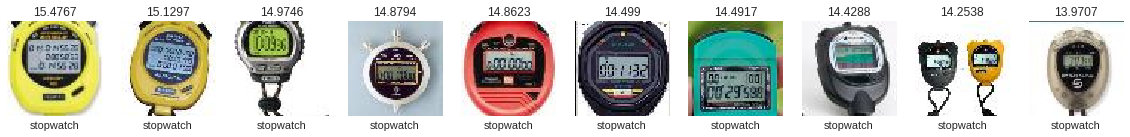

WP max activation
combination lock =


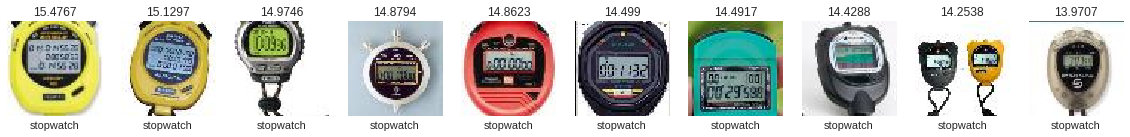

W max activation
combination lock =


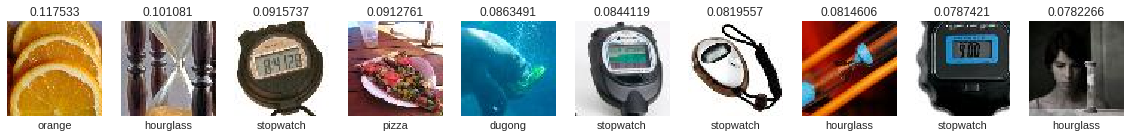

In [20]:
print('single image explaination, not orthogonal')
categories = [507]#[507]#[950]#[107, 249, 940, 1, 2, 113]
for cat in categories:
    print('WP basis')
    visContribution(newW, cat)
    print('WP max activation')
    visW(newW, A.dot(P), cat)
    print('W max activation')
    visW(W, A, cat)

In [21]:
# orthogonization
theta_list = []
for i in tqdm.tqdm(range(P.shape[1])):
    t = orthogonize(P[:,i], theta_list)
    theta_list.append(t)
newP = np.vstack(theta_list).T


 31%|███       | 1260/4096 [00:08<00:19, 148.19it/s]
Exception in thread Thread-14:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/jiaxuan/venv/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jiaxuan/venv/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 4096/4096 [01:43<00:00, 39.64it/s] 


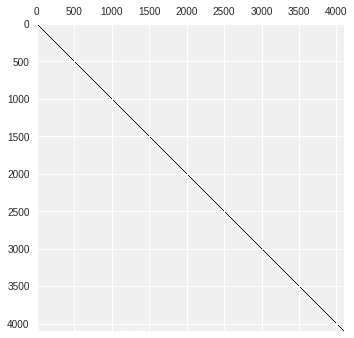

0.000141761748211
0.000949977320725


In [22]:
plt.matshow(newP.T.dot(newP))
plt.show()

print(np.abs(newP.T.dot(newP) - np.eye(W.shape[1])).mean())
print(np.abs(newP.dot(newP.T) - np.eye(W.shape[1])).mean())

In [23]:
# normalize WP
theta_list = []
for i in tqdm.tqdm(range(newP.shape[1])):
    t = newP[:,i]
    theta_list.append(normalize_theta(A, t))
new_norm_P = np.vstack(theta_list).T

100%|██████████| 4096/4096 [00:01<00:00, 2962.53it/s]


In [24]:
# normalize W
theta_list = []
W_P = np.eye(W.shape[1])
for i in tqdm.tqdm(range(W_P.shape[1])):
    t = W_P[:,i]
    theta_list.append(normalize_theta(A, t))
W_P = np.vstack(theta_list).T

100%|██████████| 4096/4096 [02:45<00:00, 24.78it/s]


single image explaination, orthogonal
WP max activation
jellyfish =


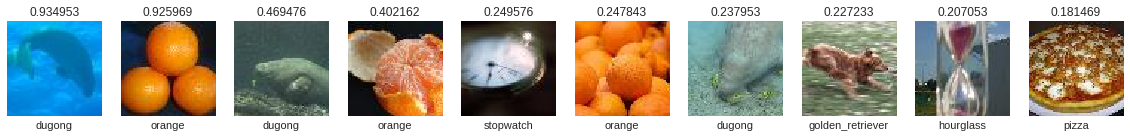

W max activation
jellyfish =


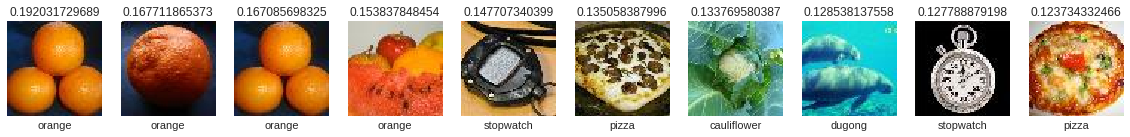

WP max activation
malamute, malemute, Alaskan malamute =


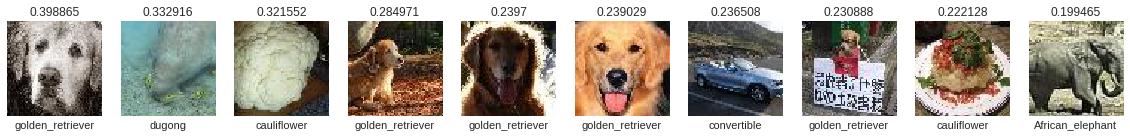

W max activation
malamute, malemute, Alaskan malamute =


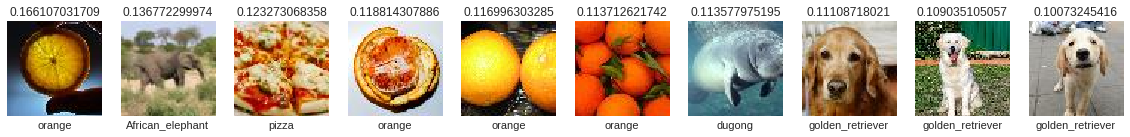

WP max activation
spaghetti squash =


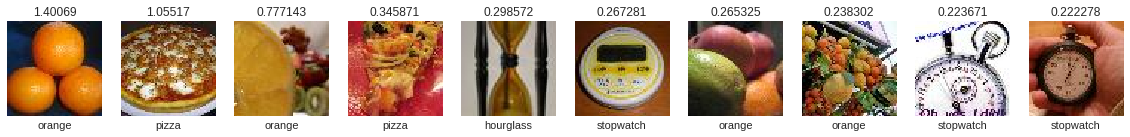

W max activation
spaghetti squash =


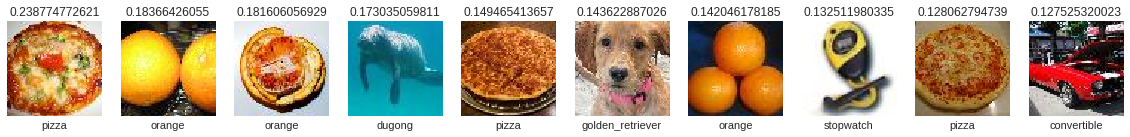

WP max activation
goldfish, Carassius auratus =


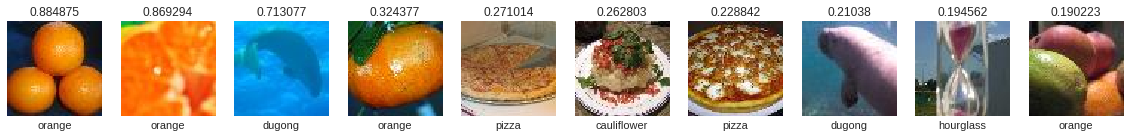

W max activation
goldfish, Carassius auratus =


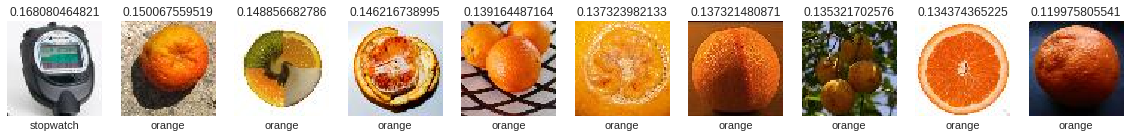

WP max activation
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias =


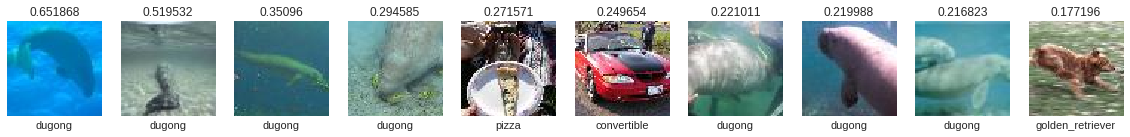

W max activation
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias =


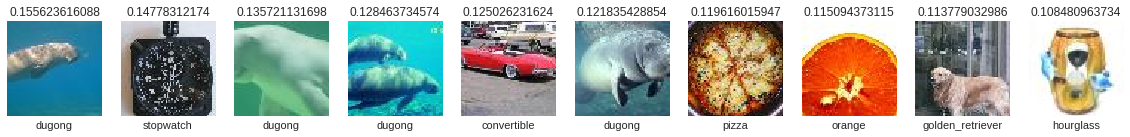

WP max activation
snail =


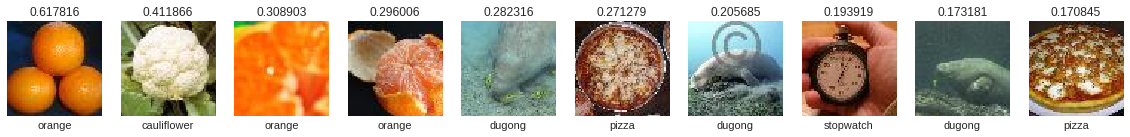

W max activation
snail =


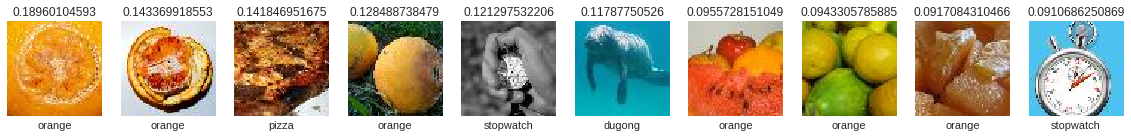

In [25]:
print('single image explaination, orthogonal')
categories = [107, 249, 940, 1, 2, 113]
for cat in categories:
    #print('WP basis')
    #visContribution(W.dot(new_norm_P), cat, use_abs=False)
    print('WP max activation')
    visW(W.dot(new_norm_P), A.dot(new_norm_P), cat, use_abs=False)
    print('W max activation')
    visW(W.dot(W_P), A, cat, use_abs=False)

# quantify interpretation

  0%|          | 3/4096 [00:00<02:35, 26.40it/s]

WP errors


100%|██████████| 4096/4096 [00:17<00:00, 232.79it/s]


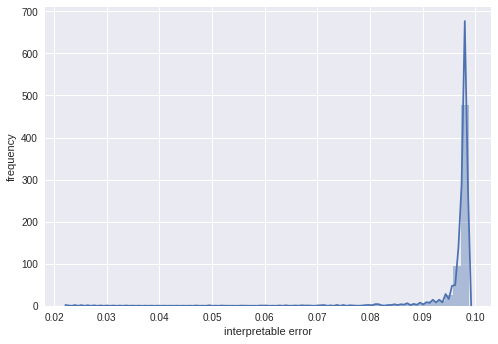

  0%|          | 2/4096 [00:00<04:42, 14.50it/s]

W errors


100%|██████████| 4096/4096 [02:51<00:00, 23.83it/s]


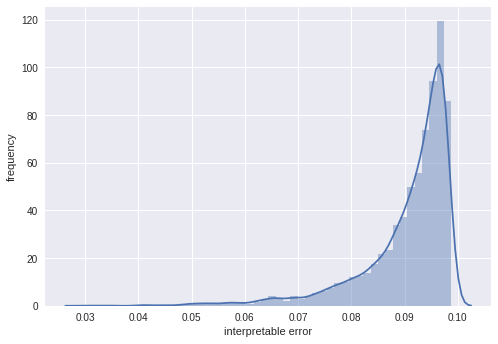

Random errors


100%|██████████| 4096/4096 [02:51<00:00, 23.85it/s]


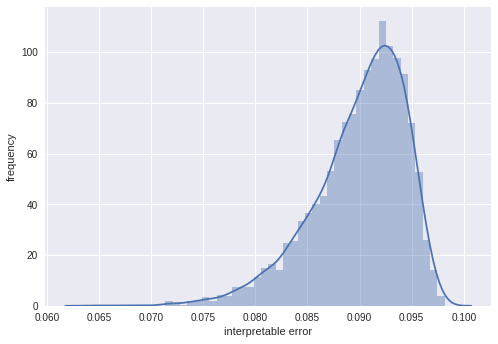

  0%|          | 18/4096 [00:00<00:26, 156.63it/s]

WP non ortho errors


100%|██████████| 4096/4096 [00:18<00:00, 216.82it/s]


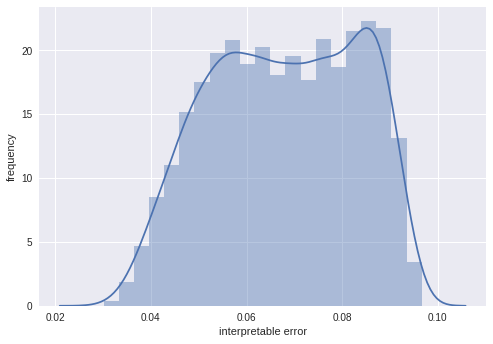

In [71]:
d = W.shape[1]
nruns = d

print('WP errors')
directions = new_norm_P.T
neuron_numbers = range(nruns)
WP_errors, WP_concepts = plot_inter_stats(directions, neuron_numbers, concepts, test_labels, A_test)

print('W errors')
directions = np.eye(d)
neuron_numbers = range(nruns)
W_errors, W_concepts = plot_inter_stats(directions, neuron_numbers, concepts, test_labels, A_test)

print('Random errors')
directions = np.random.randn(d, d)
neuron_numbers = np.random.permutation(d)[:nruns]
random_errors, random_concepts = plot_inter_stats(directions, neuron_numbers, concepts, test_labels, A_test)

print('WP non ortho errors')
directions = P.T
neuron_numbers = range(nruns)
WP_not_ortho_errors, WP_not_ortho_concepts = plot_inter_stats(directions, neuron_numbers, concepts, test_labels, A_test)

In [33]:
print_mean_std(WP_errors, "WP error")
print_mean_std(W_errors, "W error")
print_mean_std(random_errors, "Random error")
print_mean_std(WP_not_ortho_errors, "WP not ortho error")

            WP error mean: 0.097, std: 0.0046
             W error mean: 0.090, std: 0.0088
        Random error mean: 0.090, std: 0.0045
  WP not ortho error mean: 0.068, std: 0.0152


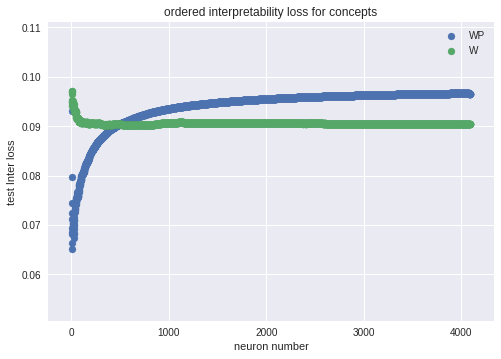

In [36]:
xs = list(range(1,d))
ys = []
for x in xs:
    ys.append(np.mean(WP_errors[:x]))
plt.scatter(xs, ys, label='WP')

ys = []
for x in xs:
    ys.append(np.mean(W_errors[:x]))
plt.scatter(xs, ys, label='W')

plt.legend()
plt.title('ordered interpretability loss for concepts')
plt.xlabel('neuron number')
plt.ylabel('test Inter loss')
plt.show()

W activations


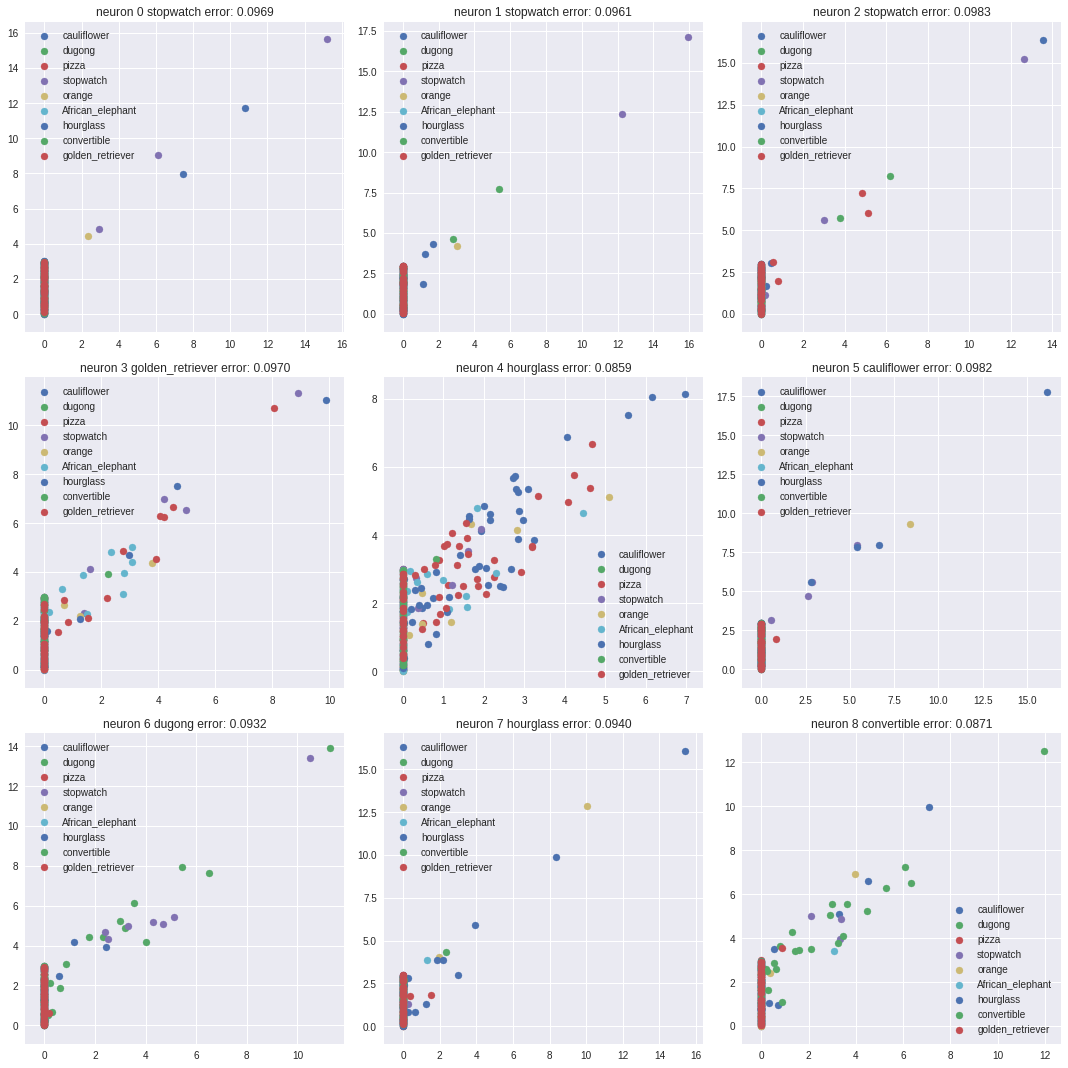

In [37]:
print('W activations')

plt.figure(figsize=(15,15))
for i in range(9):

    direction = np.zeros(d)
    direction[i] = 1
    e, m, c = interpret_direction(direction, concepts, test_labels, A_test) 
    if m < 0:
        direction = -direction
    
    plt.subplot(3,3,i+1)
    a = A_test.dot(direction)
    if a.std() != 0:
        a = a / a.std()
    concept_scatter(a, concepts, np.array(test_labels))
    plt.title('neuron %d %s error: %.4f' % (i, imagenetcodedict[c], e))

plt.tight_layout()
plt.show()

WP activations


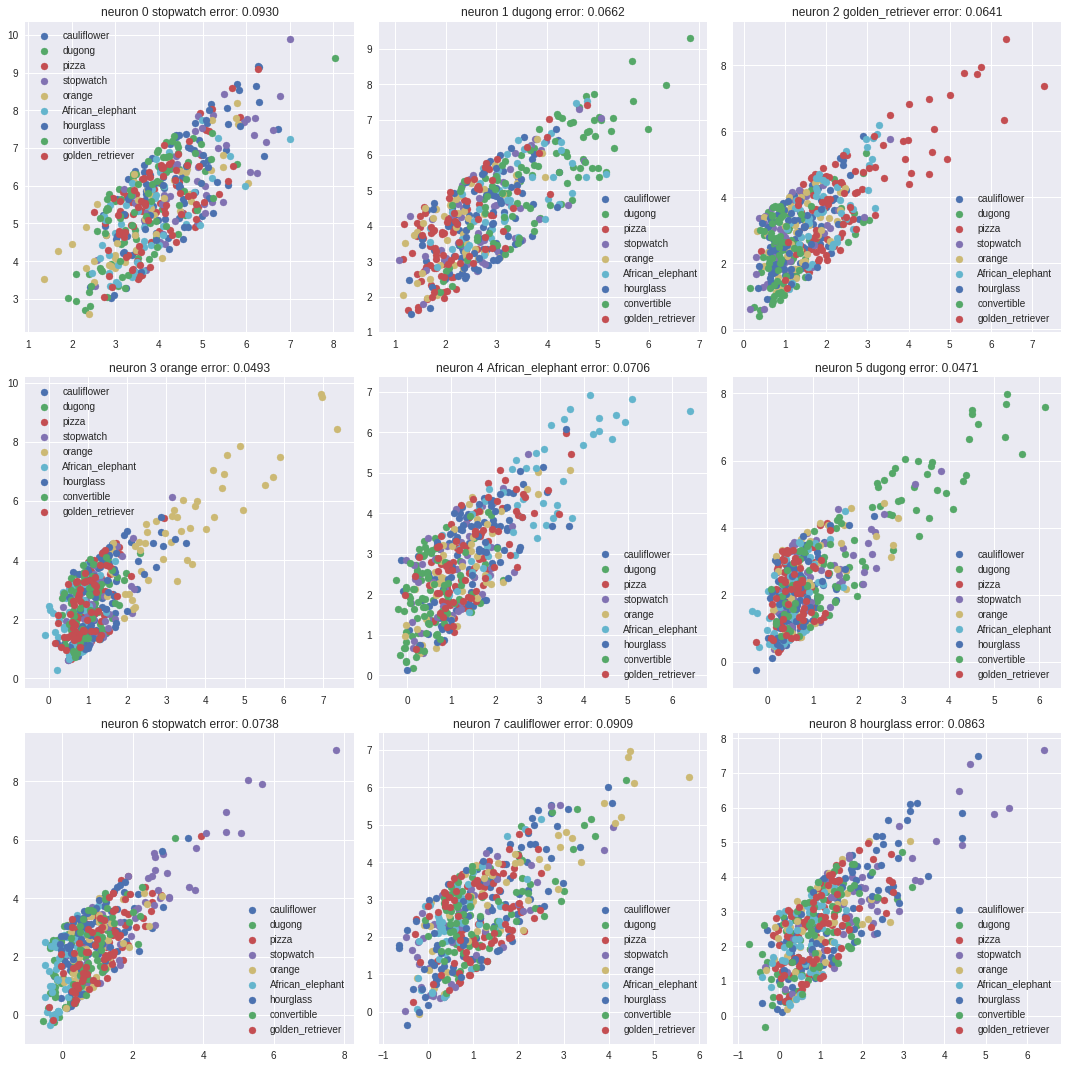

In [38]:
print('WP activations')

plt.figure(figsize=(15,15))
for i in range(9):

    direction = new_norm_P[:,i]
    e, m, c = interpret_direction(direction, concepts, test_labels, A_test)
    if m < 0:
        direction = -direction

    plt.subplot(3,3,i+1)
    a = A_test.dot(direction)
    if a.std() != 0:
        a = a / a.std()
    concept_scatter(a, concepts, np.array(test_labels))
    plt.title('neuron %d %s error: %.4f' % (i, imagenetcodedict[c], e))

plt.tight_layout()
plt.show()

# interpretability of each concept (assumption 2)

note here we are using neural network to solve least square instead of least square routine

Finished Training in 3s


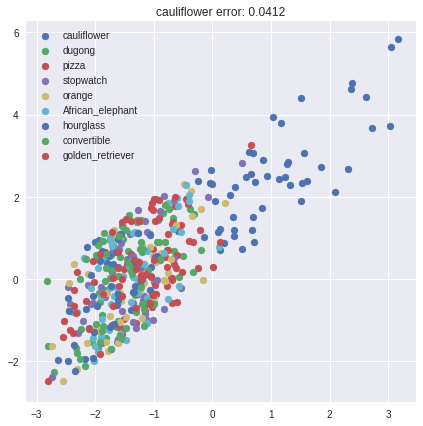

Finished Training in 3s


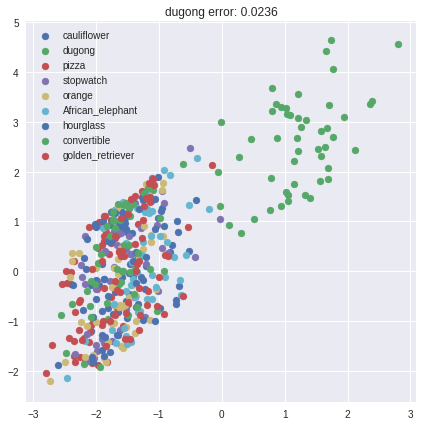

Finished Training in 3s


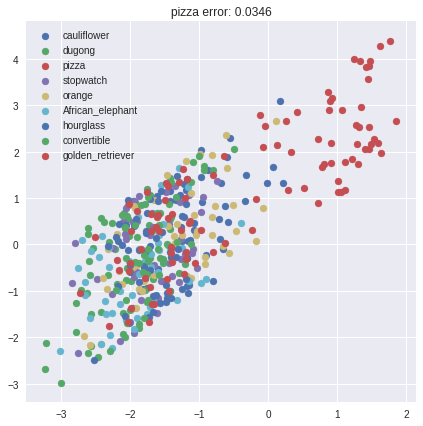

Finished Training in 3s


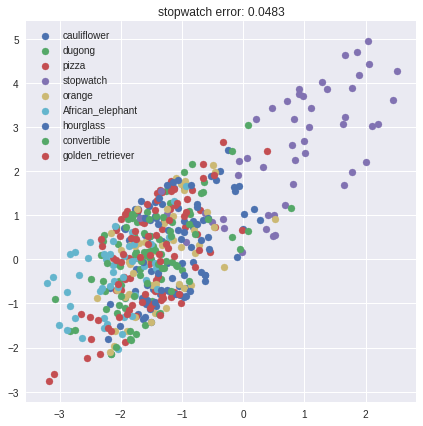

Finished Training in 3s


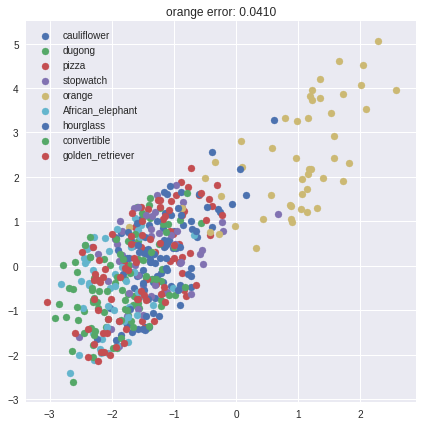

Finished Training in 3s


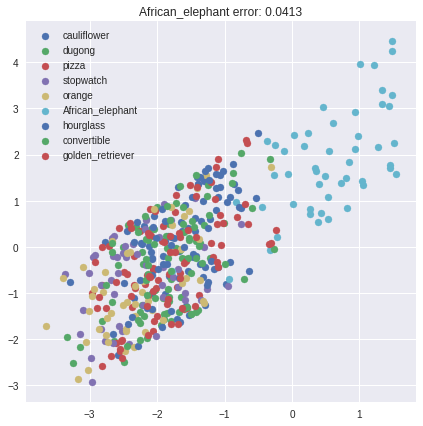

Finished Training in 3s


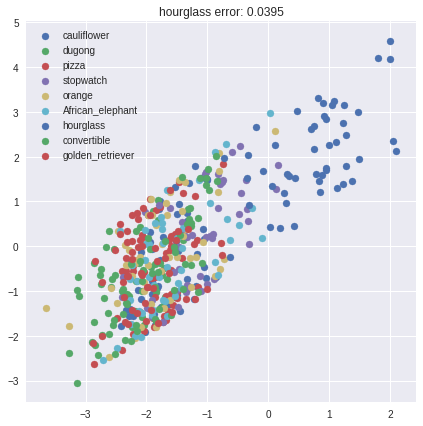

Finished Training in 3s


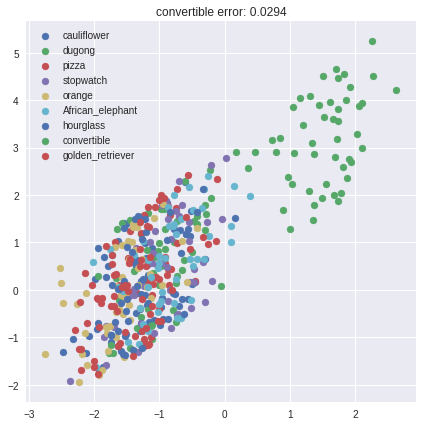

Finished Training in 3s


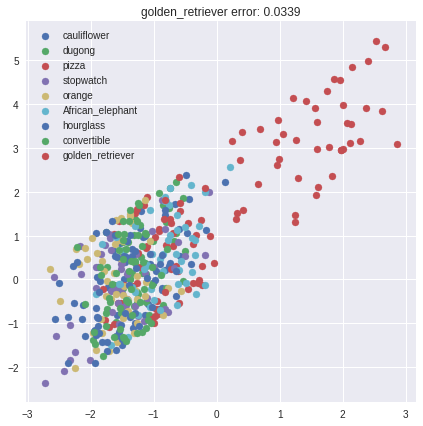

In [39]:
for c in concepts:
    y = get_y(c, labels, A)
    t = custom_solve(A, y)
    plotDirection(t, A_test, test_labels, concepts)
    plt.show()

# greedily build P

In [26]:
print('Greedy interpret anyway (order independent)')

def buildP(A, concepts_list, labels, A_test, test_labels, threshold, name):

    def data_range(A, t):
        return A.dot(t/t.dot(t)).ravel().std()

    def normalize_theta(A, t):
        drange = data_range(A, t)
        if drange == 0: # no need to normalize
            return t
        return t * drange # multiply so that in P^-1 is divide by
    
    def greedy_find_c(concepts_list, labels, A, A_test, test_labels):

        def inner_loop(c):
            theta = custom_leastsq_concept(c, labels, A)
            error, m, b = eval_direction(theta, c, test_labels, A_test)
            return theta, error, c

        n_cpu = min(int(multiprocessing.cpu_count() / 2), len(concepts_list))
        t_e_c = Parallel(n_jobs=n_cpu)(delayed(inner_loop)(c) for c in concepts_list)
        min_t, min_e, min_c = min(t_e_c, key=lambda x: x[1])
        return min_c, min_t, min_e

    A_backup = copy.deepcopy(A)
    theta_list = []

    fname =  'data/' + name + ("" if name[-4:] == ".npy" else ".npy")
    f_exist = os.path.isfile(fname)
    if f_exist:
        theta_list = np.load(fname)
        f_exist = (len(theta_list) == A.shape[1])
        
    if not f_exist:    
        print('fitting directions......')
        concepts_used = []
        errors = []
        for _ in tqdm.tqdm(range(A.shape[1])):
            min_c, theta, error = greedy_find_c(concepts_list, labels, A, A_test,test_labels)
            concepts_used.append(min_c)
            errors.append(error)
            theta = orthogonize(theta, theta_list) # just make sure theta are orthogonal # note: randomness here
            theta_list.append(theta)
            np.save("data/" + name, theta_list)
            A = A - np.outer(A.dot(theta).ravel(), theta) / np.sum(theta**2) # project data down 1 dimension

    A = copy.deepcopy(A_backup)
    P = np.vstack(theta_list).T

    errors = []
    slopes = []
    min_c = []
    for t in tqdm.tqdm(theta_list):
        e, m, c = interpret_direction(t, concepts_list, test_labels, A_test) 
        errors.append(e)
        slopes.append(m)
        min_c.append(c)

    # decorrelate unknown data using pca
    B = A.dot(ortho_inverse(P).T) # new activation
    A = []
    ind_changed = []
    for i in range(len(P)):
        if errors[i] >= threshold:
            A.append(B[:,i])
            ind_changed.append(i)
    if len(ind_changed) > 0:
        A = np.vstack(A).T
        print('doing pca %d directions need changes......' % len(ind_changed))
        pca = PCA(n_components=A.shape[1]) 
        pca.fit(A) # takes 5 min
        
        P_subset = np.vstack([P[:,i] for i in ind_changed]).T

        pca_comp = P_subset.dot(pca.components_.T) # n_comp x d
        for i, ind in enumerate(ind_changed):
            comp = pca_comp[:,i] 
            theta_list[ind] = comp

    # normalize variance
    print('normalizing variance......')
    A = copy.deepcopy(A_backup)
    theta_list = [normalize_theta(A, t) for t in theta_list]
    
    print('reevaluating direction errors......') 
    errors = []
    slopes = []
    min_c = []
    for t in tqdm.tqdm(theta_list):
        e, m, c = interpret_direction(t, concepts_list, test_labels, A_test) 
        errors.append(e)
        slopes.append(m)
        min_c.append(c)

    theta_list = list(map(lambda x: x[0] * np.sign(x[1]), zip(theta_list, slopes))) 
    P = np.vstack(theta_list).T
    np.save("data/" + name + '_final', theta_list)

    return P, errors, theta_list, min_c

Greedy interpret anyway (order independent)


In [276]:
P_greedy, errors_greedy, theta_list_greedy, min_c_greedy  = buildP(A, concepts, labels, A_test, 
                                                                   test_labels, threshold=0.071,
                                                                   name='theta_list_para')

100%|██████████| 4096/4096 [00:17<00:00, 234.70it/s]


doing pca 3827 directions need changes......
normalizing variance......


  0%|          | 5/4096 [00:00<01:23, 48.83it/s]

reevaluating direction errors......


100%|██████████| 4096/4096 [00:18<00:00, 223.85it/s]


In [277]:
theta_list = theta_list_greedy

In [108]:
# final and ordinary are the same: 'data/theta_list_para2.npy' ok
# 'data/theta_list_para.npy' ok, 'data/theta_list_para_final.npy' ok
# 'data/theta_list.npy' ok, 'data/theta_list_final.npy' ok
theta_list_unnormalized = np.load('data/theta_list_para2.npy')
print('done loading')
theta_list = []
for t in tqdm.tqdm(theta_list_unnormalized):
    theta_list.append(normalize_theta(A, t))

P_greedy = np.vstack(theta_list).T

len(theta_list)

  0%|          | 2/4096 [00:00<04:02, 16.90it/s]

done loading


100%|██████████| 4096/4096 [02:39<00:00, 25.60it/s]


4096

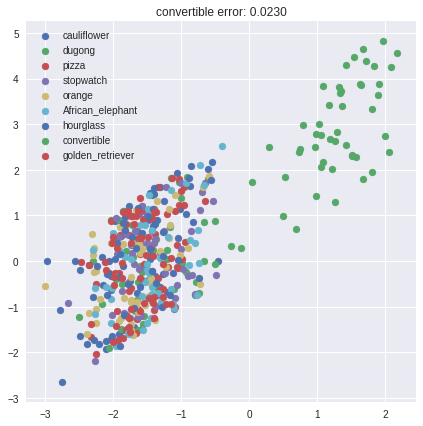

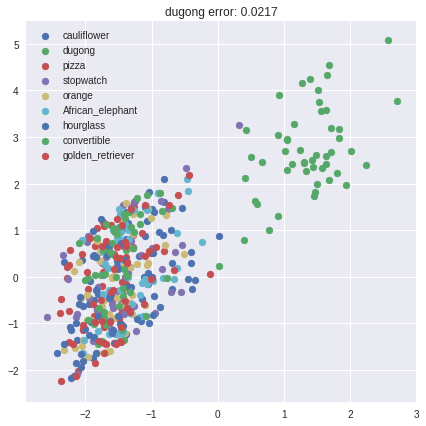

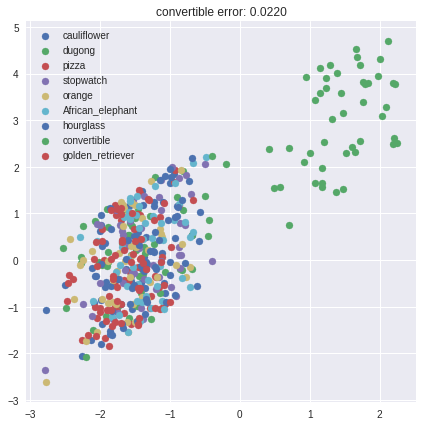

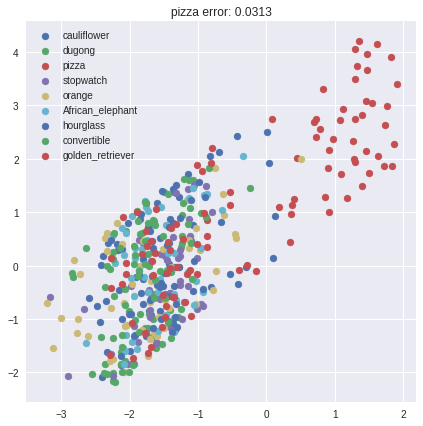

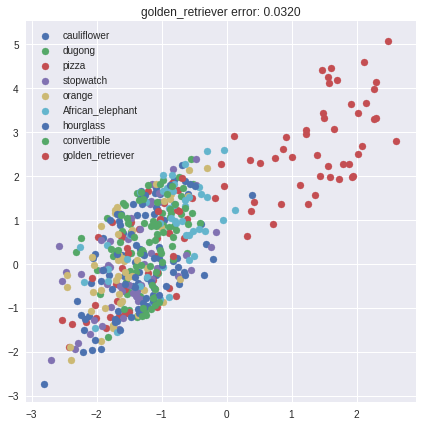

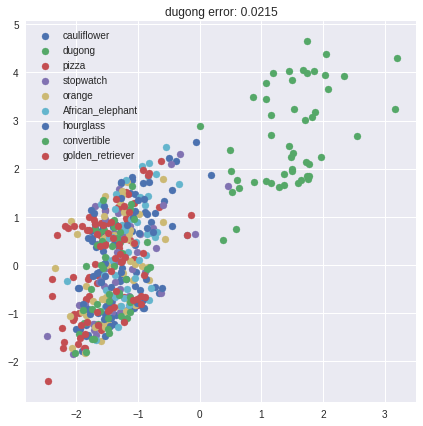

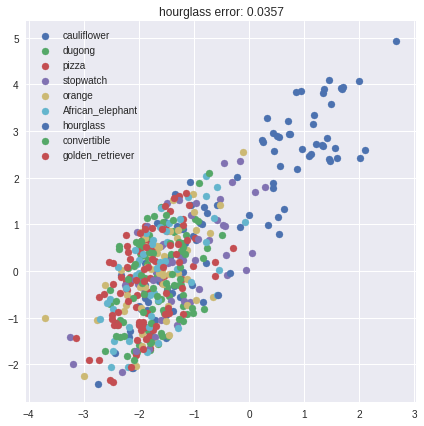

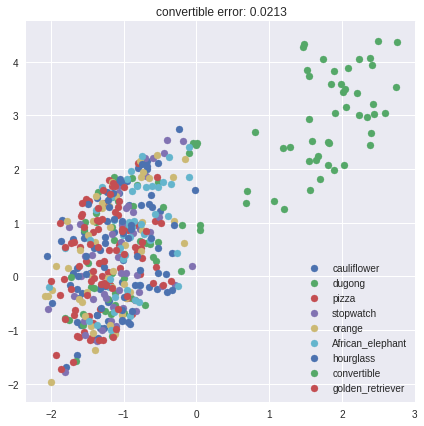

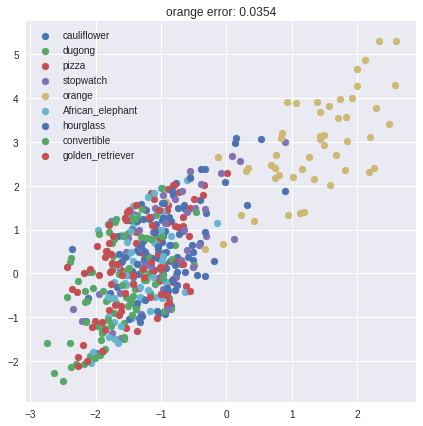

In [28]:
for t in theta_list[:9]:
    plotDirection(t, A_test, test_labels, concepts)
    plt.show()

In [109]:
greedy_errors = []
greedy_concepts = []
for t in tqdm.tqdm(theta_list):
    e, m, c = interpret_direction(t, concepts, test_labels, A_test) 
    greedy_errors.append(e)
    greedy_concepts.append(c)

100%|██████████| 4096/4096 [02:22<00:00, 28.82it/s]


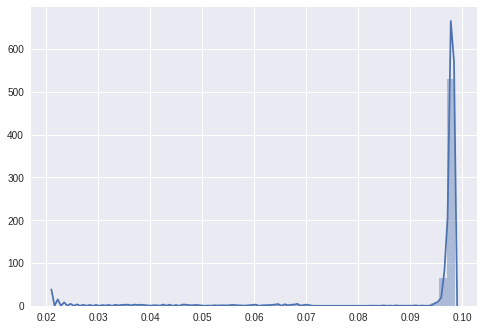

0.0947139845467


In [42]:
sns.distplot(greedy_errors)
plt.show()
print(np.mean(greedy_errors))

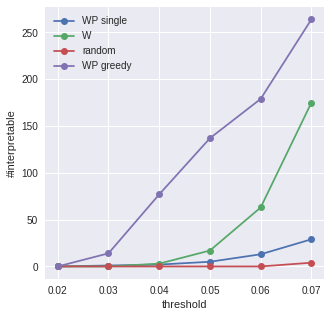

In [110]:
plt.figure(figsize=(5,5))
thresholds = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07]#, 0.08, 0.09, 0.1]
plot_number_interpretable('WP single', WP_errors, thresholds)
plot_number_interpretable('W', W_errors, thresholds)
plot_number_interpretable('random', random_errors, thresholds)
plot_number_interpretable('WP greedy', greedy_errors, thresholds)
#plot_number_interpretable('WP not ortho single', WP_not_ortho_errors, thresholds) # this is an upper bound

plt.legend()
plt.show()

In [81]:
def visW_inter(W, A, class_id, inter_errors, inter_concepts, threshold=None, top=10, reverse=False):
    '''Interpretable version to visualize W, A is the activation for showing image
       If reverse, sort from smallest to largest, else default form largest to smalles
       
       class_id: the object class to explain, e.g. 507: combination lock; the id corresponds to imagenet id
       top: show top few images
       
       inter_errors: interpretability errors of each dimension, should be a vector
       inter_concepts: interpretability concepts for each dimension
    '''
    
    word = imagenetdict[class_id]
    weights = W[class_id]

    args = np.argsort(weights)
    if not reverse:
        args = args[::-1]

    args_order = list(range(1, len(args)+1))
    if threshold is not None:
        new_args = list(filter(lambda x: inter_errors[x] <= threshold, args))
        args_order = list(filter(lambda x: inter_errors[args[x-1]] <= threshold, args_order))
        args = new_args
    selection = args[:top]

    # visualize
    print('%s =' % word)
    theta = weights[selection]
    
    # images of max activation for each neuron activation 
    W_order = np.argmax(A, axis=0)[:len(basis)]
    W_basis = np.array(basis)[W_order]
    images = np.array(W_basis)[selection]
    inter_errors = np.array(inter_errors)[selection]
    inter_concepts = np.array(inter_concepts)[selection]
    
    ncols = min(top, len(images))
    fig, ax = plt.subplots(ncols=ncols)
    fig.set_figheight(10)
    fig.set_figwidth(20)

    for i, col in enumerate(ax):
        original_image = cv2.imread(images[i])
        correct_color_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        col.imshow(correct_color_image)
        col.get_xaxis().set_ticks([])
        col.get_yaxis().set_ticks([])
        #word, class_id = predict(net, images[i])
        #word = imagenetcodedict[images[i].split('/')[-1].split('_')[0]]
        word = imagenetcodedict[inter_concepts[i]]

        if args_order[i] > 3 * top:
            col.set_title("%.2f (%d)" % (theta[i], args_order[i]), color='blue')
        else:
            col.set_title("%.2f (%d)" % (theta[i], args_order[i]))

        col.set_ylabel("%.4f" % inter_errors[i])
        col.set_xlabel(word[:18]) # set character max to avoid occluding the visualization
    plt.show()

single image explaination, not orthogonal
WP max activation with thresold=0.07
jellyfish =


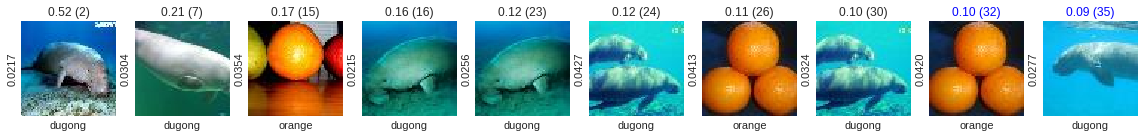

W max activation with threshold=0.07
jellyfish =


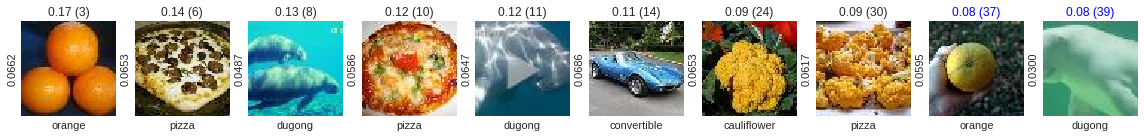

WP max activation with thresold=0.07
malamute, malemute, Alaskan malamute =


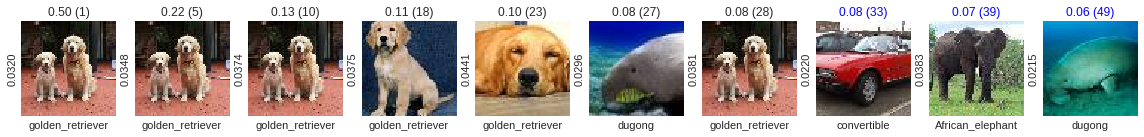

W max activation with threshold=0.07
malamute, malemute, Alaskan malamute =


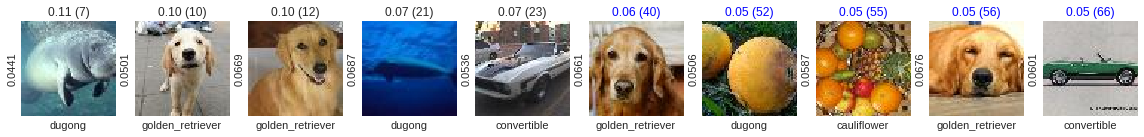

WP max activation with thresold=0.07
spaghetti squash =


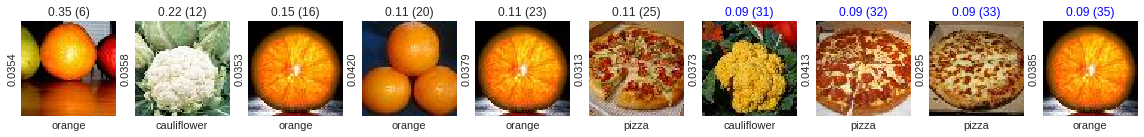

W max activation with threshold=0.07
spaghetti squash =


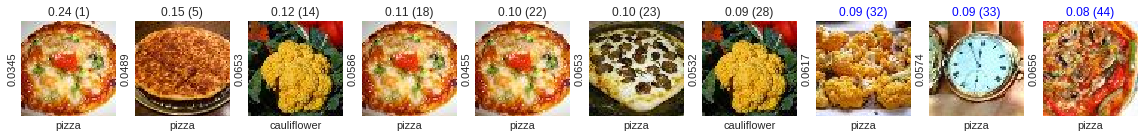

WP max activation with thresold=0.07
goldfish, Carassius auratus =


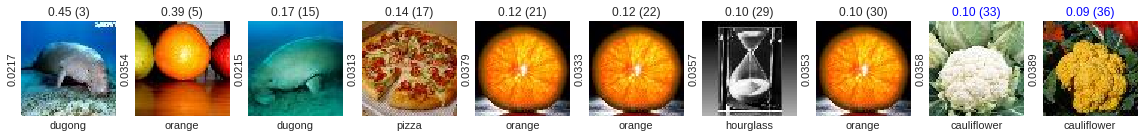

W max activation with threshold=0.07
goldfish, Carassius auratus =


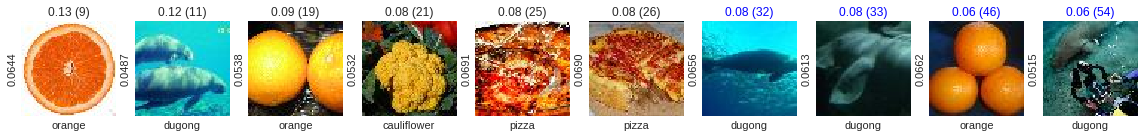

WP max activation with thresold=0.07
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias =


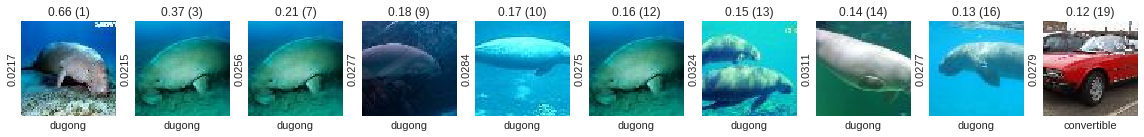

W max activation with threshold=0.07
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias =


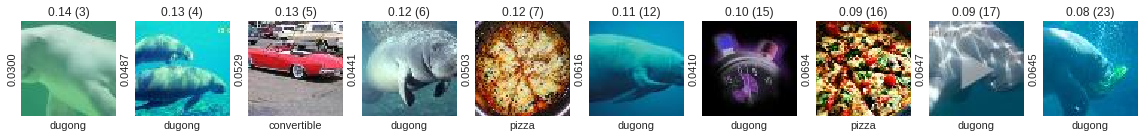

WP max activation with thresold=0.07
snail =


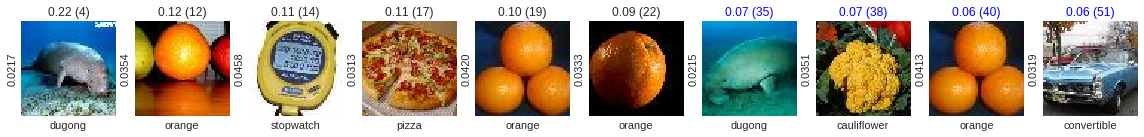

W max activation with threshold=0.07
snail =


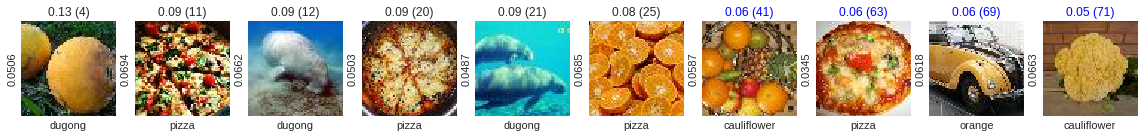

In [111]:
print('single image explaination, not orthogonal')
threshold = 0.07
categories = [107, 249, 940, 1, 2, 113]
for cat in categories:
    print('WP max activation with thresold=%.2f' % threshold)
    visW_inter(W.dot(P_greedy), A.dot(P_greedy), cat, greedy_errors, greedy_concepts, threshold=threshold)

    print('W max activation with threshold=%.2f' % threshold)
    visW_inter(W.dot(W_P), A, cat, W_errors, W_concepts, threshold=threshold)

single image explaination, not orthogonal
WP max activation no threshold
combination lock =


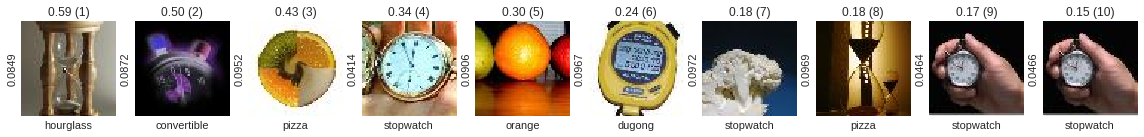

WP max activation thresold=0.07
combination lock =


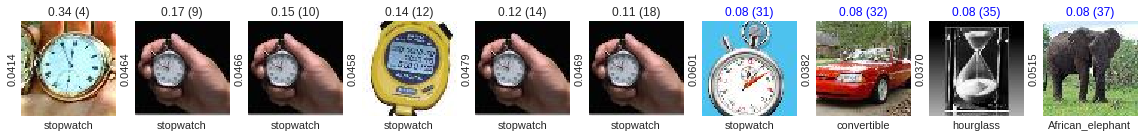

W max activation no threshold
combination lock =


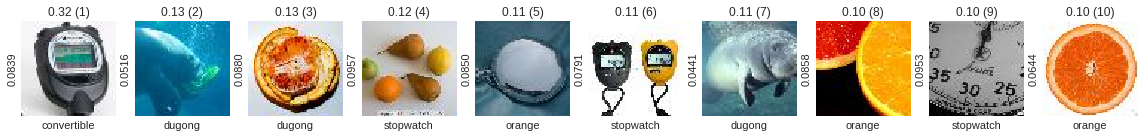

W max activation threshold=0.07
combination lock =


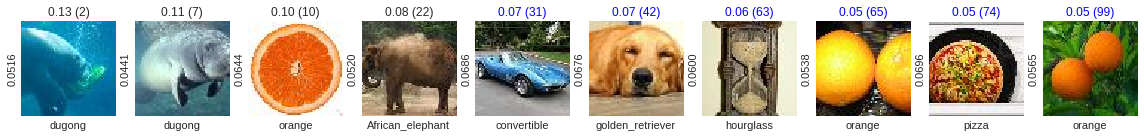

In [112]:
print('single image explaination, not orthogonal')
categories = [507] #[107, 249, 940, 1, 2, 113] # [507]
for cat in categories:
    print('WP max activation no threshold')
    visW_inter(W.dot(P_greedy), A.dot(P_greedy), cat, greedy_errors, greedy_concepts)    
    
    print('WP max activation thresold=%.2f' % threshold)
    visW_inter(W.dot(P_greedy), A.dot(P_greedy), cat, greedy_errors, greedy_concepts, threshold=threshold)

    print('W max activation no threshold')
    visW_inter(W.dot(W_P), A, cat, W_errors, W_concepts)
    
    print('W max activation threshold=%.2f' % threshold)
    visW_inter(W.dot(W_P), A, cat, W_errors, W_concepts, threshold=threshold)

# todo

1. Train on tiny imagenet (30 neurons)
2. Imagenet confounder introduce between 2 classes
3. Do a small experiment to verify which neurons are most important and somehow tradeoff this with interpretability



# train on tiny imagenet

The idea is to select say M classes, N neurons before the last layer, and then train the network until convergence

In [ ]:
num_classes = 5
num_neurons = 5